# Проверка гипотезы об использовании сервиса Яндекс Книги в зависимости от города

Исполнитель: Никитина Александра  
Email: nikilinalexa@gmail.com  
Telegram: https://t.me/alexandrakilina

## Цели и задачи проекта

Изучить поведение пользователей сервиса Яндекс.Книги из Санкт-Петербурга и Москвы. Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

Нулевая гипотеза Н0: Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза H1: Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

**Содержимое проекта**:
1. Загрузка данных и знакомство с ними\
   *Внимание! Часть информации о данных скрыта*
3. Проверка гипотезы
4. Аналитическая записка

## Загрузка данных и знакомство с ними

Данные были предварительно обработаны с использованием SQL, таблица состоит из следующих полей:
* Название города (Санкт-Петербург или Москва)
* Идентификатор пользователя
* Суммарная длительность чтения / прослушивания в часах

In [1]:
# импортируем библиотеку pandas
import pandas as pd

# установим библиотеку jupyter-black для автоматического форматирования кода
!pip install jupyter-black

# Импортируем библиотеку jupyter_black
import jupyter_black

# Импортируем библиотеки для выполнения статистических тестов
from scipy import stats as st
from scipy.stats import mannwhitneyu

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt


### Загрузка данных и знакомство с ними

In [2]:
# Сохраним данные из файла в датафрейм knigi_data
knigi_data = pd.read_csv(r'путь к файлу скрыт.csv')

In [3]:
# Выведем первые пять строк полученного датафрейма
#display(knigi_data.head())

In [4]:
# Выведем информацию о датафрейме
#knigi_data.info()

In [5]:
# посчитаем количество пропусков в каждом столбце датафрейма knigi_data в абсолютных значениях
#knigi_data.isna().sum()

*Промежуточный вывод*:  
Данные загружены и изучены, пропуски в датафрейме `knigi_data` отсутствуют

### Предобработка данных

In [6]:
# Изучим уникальные значения в категориальных данных поля city
unique_values_knigi_data = knigi_data["city"].unique()
#display (unique_values_knigi_data)

In [7]:
# Изучим дубликаты по puid (id пользователя)
# Найдем дубликаты
duplicates_puid = knigi_data.duplicated(subset='puid', keep=False)

# Создадим таблицу с дубликатами
duplicates_puid_table = knigi_data[duplicates_puid]

# Выведем на экран кол-во найденных дубликатов
print(f'Количество дубликатов {len(duplicates_puid_table)}')

Количество дубликатов 488


In [8]:
# Выведем на экран примеры срок с дубликатами
#display(knigi_data[knigi_data.duplicated('puid', keep=False)].head())

In [9]:
# Найдем дубликаты по сочетанию puid (id пользователя) и city
duplicates_knigi_data_puid_city = knigi_data.duplicated(
    subset=['city', 'puid'], keep=False
)
duplicates_knigi_data_puid_city = duplicates_knigi_data_puid_city.sum()
display(f'Количество дубликатов по сочетанию город - puid(id пользователя): {duplicates_knigi_data_puid_city}')

'Количество дубликатов по сочетанию город - puid(id пользователя): 0'

In [10]:
# Найдем дубликаты по сочетанию puid (id пользователя) и hours
duplicates_knigi_data_puid_hours = knigi_data.duplicated(
    subset=['puid', 'hours'], keep=False
)
duplicates_knigi_data_puid_hours = duplicates_knigi_data_puid_hours.sum()
display(f'Количество дубликатов по сочетанию puid (id пользователя) - количество часов: {duplicates_knigi_data_puid_hours}')

'Количество дубликатов по сочетанию puid (id пользователя) - количество часов: 0'

*Промежуточный вывод:*
- Выявлено 488 дубликата по `puid`, при этом сочетания `puid` - `city`, `puid` - `hours` yникальны

- По-видимому какие-то пользователи попали и в выборку Санкт-Петербурга, и в выборку Москвы

- Необходимо оставить только первую запись для каждого пользователя для того, чтобы они не вносили ошибку при проверке гипотезы и проведения статистического теста

In [11]:
# Удалим дубликаты по puid, оставив первое значение
knigi_filtered = knigi_data.drop_duplicates(subset='puid', keep='first')

display(f'кол-во строк в исходном датафрейме: {len(knigi_data)}')
display(f'кол-во строк в датафрейме без дубликатов: {len(knigi_filtered)}')

'кол-во строк в исходном датафрейме: 8784'

'кол-во строк в датафрейме без дубликатов: 8540'

In [12]:
# Посчитаем процент удаленных строк
percent_removed = 100* (len(knigi_data) - len(knigi_filtered)) / len(knigi_data)
display (f'Удалено {round(percent_removed, 2)}% строк')

'Удалено 2.78% строк'

*Промежуточный вывод:* Теперь неявные дубликаты отсутствуют, сформирован датафрейм `knigi_filtered`, в котором оставлены только первые записи строк, в которых дублировался `puid`

In [13]:
# Проверим наличие явных дубликатов
knigi_filtered.duplicated().sum()

0

*Промежуточный вывод:* Явные дубликаты в датафрейме `knigi_filtered` отсутствуют

### Вывод

Для дальнейшего статистического анализа сформирован датафрейм `knigi_filtered`:

* Первоначально был создан датафрейм `knigi_data` из загруженного .csv файл с информацией о пользователях сервиса Яндекс.Книги из Санкт-Петербурга и Москвы.
* Данные проверены  на наличие пропусков: пропуски отсутствуют.
* Данные проверены на наличие явных и неявных дубликатов: было выявлено отсутствие явных дубликатов, но при этом присутствовали строки, у которых совпадали puid пользователей.
* Дубликаты по puid пользователя удалены, оставлены только первые вхождения puid в датафрейм, сформирован отфильтрованный датафрейм `knigi_filtered`. Количество удаленных строк составило 2.78% строк от первоначального количества.

## Проверка гипотезы

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.
  
- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Для проверки гипотезы проверим возможность использования **t-теста** (тест Стьюдента):
* t-тест подходит для непрерывных метрик, какой и является средняя активность пользователей
* Для t-теста выборочное среднее должно быть распределено нормально, наблюдения должны быть независимимы, а выборочные дисперсии равны

In [14]:
# Выделим группы пользователей в разрезе города
st_petersburg = knigi_filtered[knigi_filtered['city'] == 'Санкт-Петербург']['hours']
moscow = knigi_filtered[knigi_filtered['city'] == 'Москва']['hours']

# Выполним тест Шапиро-Улика для каждой группы пользователей
shapiro_spb = st.shapiro(st_petersburg.dropna())
shapiro_mos = st.shapiro(moscow .dropna())
print(f'Санкт-Петербург Shapiro-W = {shapiro_spb.statistic:.3f}, p-value = {shapiro_spb.pvalue:.3g}')
print(f'Москва Shapiro-W = {shapiro_mos.statistic:.3f}, p-value = {shapiro_mos.pvalue:.3g}')

Санкт-Петербург Shapiro-W = 0.271, p-value = 0
Москва Shapiro-W = 0.293, p-value = 0


C:\Users\user\anaconda3\envs\practicum\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результаты теста Шапиро показали, что W-статистика сильно отклонена от 1 для обоих городов, а p-value стремится к нулю. Это говорит о том, что распределение сильно отклонено от нормального. Проверим, есть ли в данных выбросы и построим диаграмму размаха


In [15]:
# Выведем статистическую информацию для st_petersburg, moscow
display(st_petersburg.describe())
display(moscow.describe())

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

In [16]:
# Вычислим размах
spb_hours_max = st_petersburg.max()
spb_hours_min = st_petersburg.min()
display(f' Размах значений hours для Санкт-Петербурга: {round(spb_hours_max - spb_hours_min)} часов')

msc_hours_max = moscow.max()
msc_hours_min = moscow.min()
display(f' Размах значений hours для Москвы: {round(msc_hours_max - msc_hours_min)} часов')

' Размах значений hours для Санкт-Петербурга: 979 часов'

' Размах значений hours для Москвы: 857 часов'

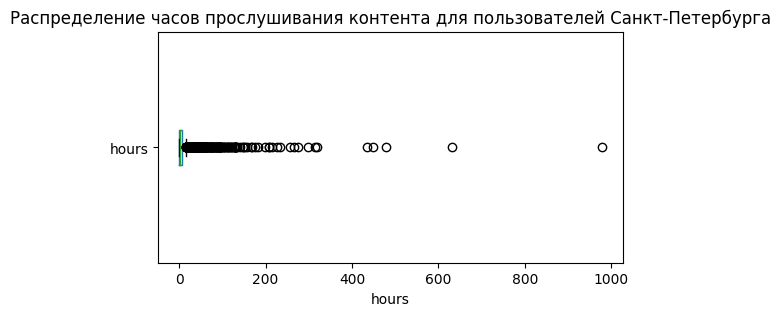

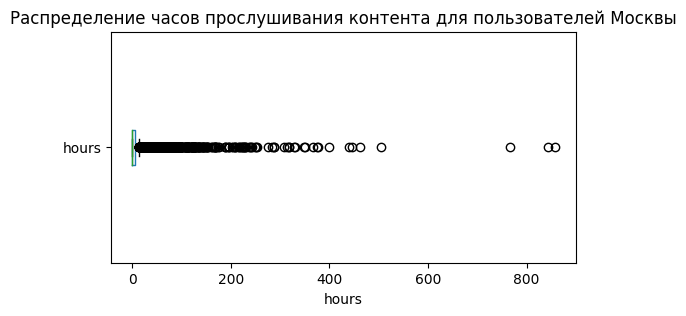

In [17]:
# Строим диаграмму размаха методом plot.box()
boxplot = st_petersburg.plot.box(vert = False,
                               figsize = (6, 3))
# Добавляем заголовок и метку оси Х
boxplot.set_title('Распределение часов прослушивания контента для пользователей Санкт-Петербурга')
boxplot.set_xlabel('hours')
plt.show()

# Строим диаграмму размаха методом plot.box()
boxplot = moscow.plot.box(vert = False,
                               figsize = (6, 3))
# Добавляем заголовок и метку оси Х
boxplot.set_title('Распределение часов прослушивания контента для пользователей Москвы')
boxplot.set_xlabel('hours')
plt.show()

*Промежуточный вывод:*  
И для пользоватлей из Санкт-Петербурга, и из Москвы наблюдается сильный разброс значений длительности в часах. Размах значений для СПб составил 979 часов, а для Москвы - 857 часов. Судя по диагамме размаха, для обоих наборов данных характерно наличие выбросов в большую сторону.

Таким образом, для проверки гипотезы необходимо применить непараметрический **тест Манна-Уитни**, который не требует равенства дисперсий и нормальности распределения.

In [18]:
# Уровень статистической значимости
alpha = 0.05

# Применяем тест Манна-Уитни
stat_mw, p_value_mw = mannwhitneyu(
    st_petersburg, 
    moscow,
    alternative='greater'
)

print('p-значение:', round(p_value_mw, 4))

if p_value_mw < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.619
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
* Была проверена возможность использования t-теста для проверки гипотез с использованием теста Шапиро
* Тест Шапиро показал, что распределение сильно отклонено от нормального, t-тест Стьюдента неприменим. Разброс значений был показан с использованием диаграмм размаха. Кроме того, при выводе статистик видно, что и для Санкт-Петербурга, и для Москвы, среднее и медианное значение сильно отличаются, что также говорит об асимметрии в данных.
* Для проверки гипотез использовался непараметрический тест Манна-Уитни, который показал, что нулевую гипотезу не получилось отпровергнуть, так как p-значение составляет 0.0831

***Результат:*** Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

## Аналитическая записка

Был проведен анализ гипотезы о том, что пользователи из Санкт-Петербурга больше времени за чтением и прослушиванием книг в приложении в сравнении с пользователями из Москвы.

- Данные были изучены и отфильтрованы дубликаты

- Был выбран непараметрический тест Манна-Уитни о равенстве средних двух выборок. Причина выбора данного статистического теста: тест Шапиро показал, что распределение сильно отклонено от нормального, t-тест неприменим

- Уровень статистической значимости alpha был выбран 0.05.

- Значение p-value составило 0.0831, p-value больше alpha, нулевая гипотеза не отвергнута.

- Нулевая гипотеза не отвергнута, так как p-value больше alpha, таким образом,  гипотеза о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы, не подтверждена

- Возможные причины связаны с тем, что и в Санкт-Петербурге, и в Москве доля образованных людей идентична. Также для больших городов характерно схожее поведение пользователей из-за демографического распределения.

